# <b>Линейные алгоритмы</b>


Здесь мы напишем свой класс логистической регрессии для бинарной классификации, а также логистическую регрессию с регуляризацией.

In [8]:
import numpy as np
import pandas as pd
import scipy.linalg as sla
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [9]:
np.random.seed(42)

# Генератор батчей

Создадим генератор батчей. Мы хотим, чтобы в течение одной эпохи модель обучилась на каждом примере один раз. Для этого нужно перемешать строчки в датасете и каждый раз брать очередные *batch_size* строчек. 

Может так получится, что размер датасета не делится на *batch_size*, тогда последний батч будет состоять из нескольких последних строк и его размер будет меньше, чем *batch_size*. Такой батч иногда выкидывают и просто не используют. Именно так нам и нужно поступить.

Напишем генератор батчей, который будет принимать на вход признаки, ответы и размер батча. Генератор должен возвращать tuple из ($X_{batch}$, $y_{batch}$). Если размер датасета не делится на batch_size, то **последний маленький батч возвращать не нужно**. 

Подробнее про Python генераторы можно прочитать здесь:

[Документация](https://wiki.python.org/moin/Generators)

[Описание на русском](https://pythoner.name/list-generator)

Чтобы не перемешивать сам датасет воспользуемся np.random.permutation(len(X))


In [39]:
def generate_batches(X, y, batch_size):
    """
    param X: np.array[n_objects, n_features] --- матрица объекты-признаки
    param y: np.array[n_objects] --- вектор целевых переменных
    """
    assert len(X) == len(y)
    np.random.seed(42)
    X = np.array(X)
    y = np.array(y)
    perm = np.random.permutation(len(X))

    batch_count = len(X) // batch_size
    for batch_start in range(batch_count):
        inds = perm[batch_start * batch_size:(batch_start + 1) * batch_size]
        X_batch = X[inds]
        y_batch = y[inds]
        yield (X_batch, y_batch)

# Тестируем написанную функцию

Проверим, что наш генератор батчей перемешивает датасет и каждый элемент встречается один раз:

In [40]:
X_fake = np.arange(100)[:, np.newaxis]
y_fake = np.arange(100) + 1000

X_reconstructed, y_reconstructed = [], []
for X_batch, y_batch in generate_batches(X_fake, y_fake, 10):
    X_reconstructed.append(X_batch)
    y_reconstructed.append(y_batch)

X_reconstructed = np.concatenate(X_reconstructed)
y_reconstructed = np.concatenate(y_reconstructed)

assert (X_fake != X_reconstructed).all(), "Что-то не так!"
assert (y_fake != y_reconstructed).all(), "Что-то не так!"

assert (np.sort(X_reconstructed, axis=0) == X_fake).all(), "Что-то не так!"

Попробуем теперь *batch_size* не делящий размер датасета.

In [41]:
X_fake = np.arange(100)[:, np.newaxis]
y_fake = np.arange(100) + 1000

num_batches = 0
for X_batch, y_batch in generate_batches(X_fake, y_fake, 7):
    num_batches += 1

assert num_batches == len(X_fake) // 7, "Что-то не так!"

# Обычная логистическая регрессия 
В этом пункте мы напишем класс логистической регрессии. Пока мы не будем добавлять в функцию потерь регуляризационные слагаемые. 

Нам необходимо будет воспользоваться оптимизацией с помощью SGD, используя генератор батчей, который мы написали выше.

Реализуем методы ``fit`` и ``get_grad`` класса ``MyLogisticRegression``. 


Напоминаем формулы:

$$Loss(y, p) = -\sum_{i=1}^{l} (y_i \log (p_i) + (1 - y_i) \log (1 - p_i))$$


$$ \frac{\partial L}{\partial w} = X^T (p - y)$$


In [42]:
def logit(x, w):
    return np.dot(x, w)

def sigmoid(h):
    return 1. / (1 + np.exp(-h))

In [43]:
class MyLogisticRegression(object):
    def __init__(self):
        self.w = None
    
    def fit(self, X, y, epochs=10, lr=0.1, batch_size=100):
        n, k = X.shape        
        if self.w is None:
            np.random.seed(42)
            # Вектор столбец в качестве весов
            self.w = np.random.randn(k + 1)

        X_train = np.concatenate((np.ones((n, 1)), X), axis=1)
        
        losses = []

        # Положим в лист losses лосс на каждом батче. Не будем усреднять лосс по эпохе.

        for i in range(epochs):
            for X_batch, y_batch in generate_batches(X_train, y, batch_size):
                #В X_train уже добавлен вектор 1

                predictions = sigmoid(logit(X_batch, self.w))# предскажем вероятности на X_batch
                predictions = np.clip(predictions, 1e-10, 1 - 1e-10)
                # вычислим loss на текущем батче 
                loss = np.array(y_batch * np.log(predictions) + (1 - y_batch) * np.log(1 - predictions)).shape[0]
                                                
                assert (np.array(loss).shape == tuple()), "Лосс должен быть скаляром!" 

                losses.append(self.__loss)
                
                # обновим self.w по формуле градиентного спуска.
                # используем функцию self.get_grad для вычисления градиента. Не забудьте про learning rate!
                self.w -= self.get_grad(X_batch, y_batch, predictions) * lr
        return losses    
    def get_grad(self, X_batch, y_batch, predictions):
        """

        param X_batch: np.array[batch_size, n_features + 1] --- матрица объекты-признаки
        param y_batch: np.array[batch_size] --- батч целевых переменных
        param predictions: np.array[batch_size] --- батч вероятностей классов

        Принимает на вход X_batch с уже добавленной колонкой единиц. 
        Выдаёт градиент функции потерь в логистической регрессии
        как сумму градиентов функции потерь на всех объектах батча
        ВНИМАНИЕ! Нулевая координата вектора весов -- это BIAS, а не вес признака. 
        Также не нужно ДЕЛИТЬ ГРАДИЕНТ НА РАЗМЕР БАТЧА:
        нас интересует не среднее, а сумма. 
        В качестве оператора умножения матриц можно использовать @ 

        Выход -- вектор-столбец градиентов для каждого веса (np.array[n_features + 1])
        """

        #компонент градиента из логрегрессии 
        #следите за размерностями
        
        grad_basic = np.dot(X_batch.T, (predictions - y_batch))
        assert grad_basic.shape == (X_batch.shape[1],) , "Градиенты должны быть столбцом из k_features + 1 элементов"

        return grad_basic
        
    def predict_proba(self, X):
        n, k = X.shape
        X_ = np.concatenate((np.ones((n, 1)), X), axis=1)
        return sigmoid(logit(X_, self.w))

    def _predict_proba_internal(self, X): 
        """
        Возможно, вы захотите использовать эту функцию вместо predict_proba, поскольку
        predict_proba конкатенирует вход с вектором из единиц, что не всегда удобно
        для внутренней логики вашей программы
        """
        return sigmoid(logit(X, self.w))

    def predict(self, X, threshold=0.5):
        return self.predict_proba(X) >= threshold
    
    def get_weights(self):
        return self.w.copy() 
        # copy тут используется неспроста. Если copy не использовать, то get_weights()
        # выдаст ссылку на объект, а, значит, модифицируя результат применения функции
        # get_weights(), мы модифицируем и веса self.w. Если мы хотим модифицировать веса, 
        # (например, в fit), используем self.w
      
    def __loss(self, y, p):  
        p = np.clip(p, 1e-10, 1 - 1e-10)
        return -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))

## Тестируем написанную функцию


In [44]:
m = MyLogisticRegression()
X = np.array([[1, 3, 4], [1, -5, 6], [-3, 5, 3]])
X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
y = np.array([1, 0, 1])
preds = np.array([.55, .22, .85])
grads = m.get_grad(X, y, preds) 
assert np.allclose(grads, np.array([-0.38,  0.22, -3.2 , -0.93])), "Что-то не так!"

In [45]:
np.random.seed(42)
m = MyLogisticRegression()
X = np.random.rand(100,3)
y = np.random.randint(0, 1, size=(100,))
preds = np.random.rand(100)
grads = m.get_grad(X, y, preds) 
assert np.allclose(grads, np.array([23.8698149, 25.27049356, 24.4139452])), "Что-то не так!"

# Логистическая регрессия с $l_1$ и $l_2$ регуляризацией (elastic net).

Напишем класс логистической регрессии с обеими регуляризациями и оптимизацией с помощью SGD, используя генератор батчей, который мы написали выше.

Обратите внимание, что реализация ElasticNet отличается от реализации LogisticRegression только функцией потерь для оптимизации. Поэтому единственная функция, которая будет отличаться у двух методов, это ``self.get_grad()``. 

Поэтому в данном случае естественно применить паттерн *наследования*.

Реализуем метод ``get_grad()`` класса ``MyElasticLogisticRegression`` 

Формулы:

$$L_1 (w) = \alpha \sum_{j=1}^{n}|w_j| $$

$$L_2 (w) = \beta\sum_{j=1}^{n}w_j^2$$

$$\frac{\partial L_1}{\partial w_1} = \alpha \cdot \mathrm{sign}(w_1)$$

$$ \frac{\partial L_2}{\partial w_1} = 2\beta w_1$$


In [46]:
class MyElasticLogisticRegression(MyLogisticRegression):
    def __init__(self, l1_coef, l2_coef):
        self.l1_coef = l1_coef
        self.l2_coef = l2_coef
        self.w = None

    def get_grad(self, X_batch, y_batch, predictions):
        """
        Принимает на вход X_batch с уже добавленной колонкой единиц. 
        Выдаёт градиент функции потерь в логистической регрессии с регуляризаторами
        как сумму градиентов функции потерь на всех объектах батча + регуляризационное слагаемое
        ВНИМАНИЕ! Нулевая координата вектора весов -- это BIAS, а не вес признака. 
        Bias в регуляризационные слагаемые не входит. Также не нужно ДЕЛИТЬ ГРАДИЕНТ НА РАЗМЕР БАТЧА:
        нас интересует не среднее, а сумма. 

        Выход -- вектор-столбец градиентов для каждого веса (np.array[n_features + 1])
        """


        grad_basic = np.dot(X_batch.T, (predictions - y_batch))#компонент градиента из логрегрессии. Обнулять bias-компоненту этой составляющей градиента не нужно!

        grad_l1 = self.l1_coef*np.sign(self.w)# компонент градиента из l_1-регуляризации (не забудьте обнулить компоненту с bias)
        grad_l2 = 2*self.l2_coef*self.w# компонент градиента из l_2-регуляризации (не забудьте обнулить компоненту с bias)
        grad_l1[0] = 0
        grad_l2[0] = 0
        #Обнулять bias-компоненту вектора весов не нужно!

        assert grad_l1[0] == grad_l2[0] == 0, "Bias в регуляризационные слагаемые не входит!"
        assert grad_basic.shape == grad_l1.shape == grad_l2.shape == (X_batch.shape[1],) , "Градиенты должны быть столбцом из k_features + 1 элементов"

        return grad_basic + grad_l1 + grad_l2

## Тестирование
Протестируем написанную функцию:


In [47]:
m = MyElasticLogisticRegression(.2,.2) 
X = np.array([[1, 3, 4], [1, -5, 6], [-3, 5, 3]])
X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
y = np.array([1, 0, 1])
preds = np.array([.55, .22, .85])
m.w = np.array([1,1,1,1])
grads = m.get_grad(X, y, preds)
assert np.allclose(grads, np.array([-0.38,  0.82, -2.6 , -0.33])), "Что-то не так!"


In [48]:
np.random.seed(42)
m = MyElasticLogisticRegression(.2, .2)
X = np.random.rand(100,3)
X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
y = np.random.randint(0, 1, size=(100,))
preds = np.random.rand(100)
m.w = np.array([1,1,1,1])
grads = m.get_grad(X, y, preds)
assert np.allclose(grads, np.array([49.11489408, 24.4698149, 25.87049356, 25.0139452])), "Что-то не так!"


## Смотрим, как работает наша модель
Протестируем на искусственных данных:

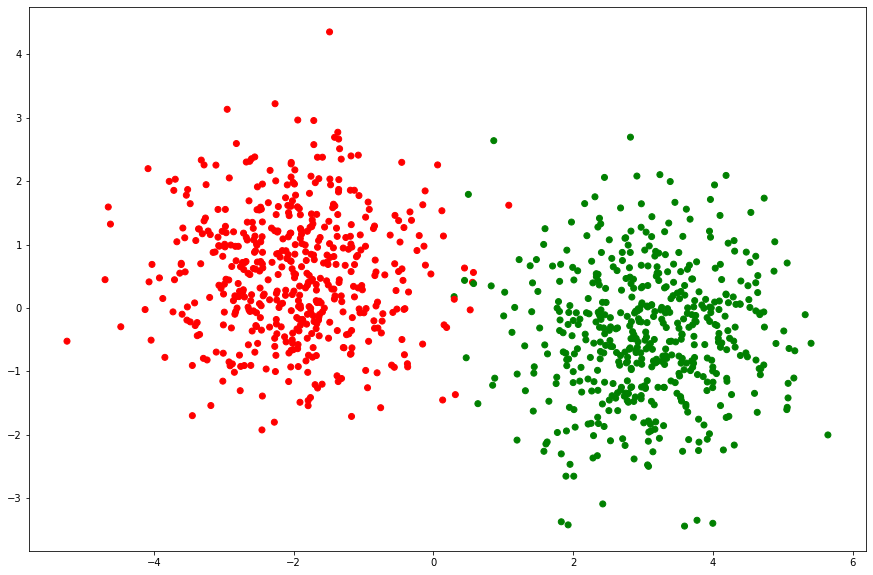

In [49]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000, centers=[[-2,0.5],[3,-0.5]], cluster_std=1, random_state=42)
#y = y.reshape(-1, 1)

colors = ("red", "green")
colored_y = np.zeros(y.size, dtype=str)

for i, cl in enumerate([0,1]):
    colored_y[y.ravel() == cl] = str(colors[i])
    
plt.figure(figsize=(15,10))
plt.scatter(X[:, 0], X[:, 1], c=colored_y)
plt.show()

In [50]:
clf = MyElasticLogisticRegression(0.1, 0.1)
clf.fit(X, y, epochs=1000)
w = clf.get_weights()

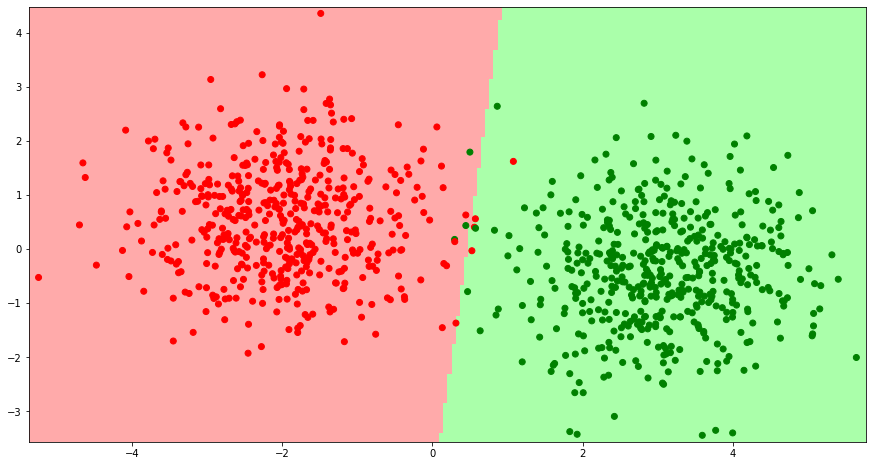

In [51]:
from matplotlib.colors import ListedColormap

plt.figure(figsize=(15,8))

eps = 0.1
xx, yy = np.meshgrid(np.linspace(np.min(X[:,0]) - eps, np.max(X[:,0]) + eps, 200),
                     np.linspace(np.min(X[:,1]) - eps, np.max(X[:,1]) + eps, 200))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

plt.scatter(X[:, 0], X[:, 1], c=colored_y)